# Text similarity and cosine similarity

Compare the words contained within sentences and get the similarity of the sentences.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import html
import joblib
import time
from sklearn.feature_extraction.text import TfidfVectorizer # weight given to word occurrences
from sklearn.feature_extraction.text import CountVectorizer # irrespective of word occurrences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

Taking data from some related BBC News articles, the text information can be compared.

In [2]:
text1 = """Scotland's economy secretary Màiri McAllan is pregnant and will take maternity leave this summer, it has been confirmed.

It will be the second time a serving Scottish cabinet secretary has taken maternity leave after Kate Forbes's pregnancy in 2022.

Arrangements to cover Ms McAllan's ministerial responsibilities will be set out by the first minister.

The Scottish government said she will resume her duties on her return.

A spokesperson added she notified Humza Yousaf of her pregnancy at the beginning of the year.

Ms McAllan, 31, was previously transport secretary - a brief that was taken over by Fiona Hyslop in a reshuffle earlier in February after Michael Matheson resigned.

Ms McAllan took over the economy brief from Neil Gray, who was appointed health secretary. She is currently the wellbeing economy, net zero and energy secretary.

Ms McAllan said she was "laser-focused" on delivering her portfolio priorities.

"My husband Iain and I are delighted that we are expecting our first child in the summer, and very much look forward to welcoming this new addition to our family," she said.

"I will spend the coming months setting the groundwork for all I believe needs to be done pursuant to this. That way, work can continue in my absence and I can seamlessly pick back up on my return.

"I hope my example will send a strong signal to all women and girls - and to Scotland more generally - that starting a family should never be a barrier to holding senior positions within any organisation and that, as a nation, we are stronger when our politics and government reflect our society."

Mr Yousaf offered his congratulations to Ms McAllan on the "fantastic news".

He said: "I am pleased Màiri has agreed to remain cabinet secretary for wellbeing economy, net zero and energy while on leave, and take up her duties again upon her return after spending some treasured time with the exciting new addition to her family."

Ms McAllan told the Sunday Mail newspaper that her baby is due at the end of July."""

In [3]:
text2 = """Scotland's finance secretary Kate Forbes is pregnant and will be taking maternity leave in the summer, it has been announced.

It will be the first time a serving Scottish cabinet secretary has taken maternity leave.

Arrangements to cover her ministerial responsibilities while she is on leave will be set out by the first minister.

Ms Forbes has been finance secretary for two years, and has been tipped as a possible future first minister.

She has been working on finalising the Scottish government's budget plans for the coming year, which are due to be passed by MSPs on Thursday.

The government said she will remain as finance secretary while she is on maternity leave and will resume her duties upon her return on a date that has not yet been agreed.

In a statement, Ms Forbes said she and her husband Alasdair MacLennan - who she married in Dingwall in July of last year - were expecting their first child together later this year, and were "looking forward to welcoming a new member of our family".

She confirmed that she planned to take maternity leave from Holyrood, but said her office and team would still be available to help residents in her Skye, Lochaber and Badenoch constituency.

Ms Forbes, 31, said her pregnancy had given her an "even deeper admiration for the thousands of women across the country who balance both work and personal responsibilities".

This article contains content provided by Twitter. We ask for your permission before anything is loaded, as they may be using cookies and other technologies. You may want to read Twitter’s cookie policy, external and privacy policy, external before accepting. To view this content choose ‘accept and continue’.

She added: "There might be particular challenges with being a politician in the public eye, whilst combating the side effects of pregnancy, but it is an experience which is familiar to countless women.

"Politics, like many workplaces, is often not renowned for being a supportive environment for parents.

"Hopefully I can play a small part in changing that, and demonstrating that it is possible to have children and a career, with the right support in place."

First Minister Nicola Sturgeon said she was pleased that Ms Forbes "will be able to enjoy those precious early months with her new arrival and her wider family".

She added: "This should never be a barrier to someone's career, especially women in senior leadership roles.

"That is why we are clear Kate is not leaving government. She will remain Cabinet Secretary for Finance and the Economy while on leave and take up her duties again upon her return."

Ms Forbes - who is the only woman to have ever served as finance secretary - is a member of the Free Church of Scotland, which follows a strict interpretation of the Bible.

She described last year how she had often had to "tiptoe around" her Christian faith because of a "fear and a sense that the public will think we only speak for our own rather than speak for everybody".

Although Ms Forbes will be the first cabinet secretary to take maternity leave, Aileen Campbell took maternity leave while serving as minister for children and young people in December 2014."""

# ETL the data (load, process and transform)

In [4]:
# clean the text and split into sentences, splitting by a fullstop

text_to_clean = [text1, text2]
source = ["news1", "news2"]

# apply a text cleaning function to column reviewText
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text in code or brackets
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of whitespaces
    text = re.sub(r'\s+', ' ', text)
    # make lower case
    #text = text.lower()
    # remove speech marks
    text = re.sub('"', '', text)
    
    return text.strip()

cleaned_text = pd.DataFrame()

#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*
make_single_text = False # to make one big piece of text
#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*

for each_text, source_name in zip(text_to_clean, source):
    cleaned = clean(each_text)
    cleaned = cleaned.split(".")
    if make_single_text == True:
        # optional - join to make one big piece of text
        cleaned = '.'.join(cleaned)
        cleaned_df = pd.DataFrame({'text':[cleaned], 'source':source_name})
        cleaned_text = pd.concat([cleaned_text, cleaned_df],ignore_index = True)
    else:
        cleaned_df = pd.DataFrame({'text':cleaned, 'source':source_name}) # when not using option above
        cleaned_text = pd.concat([cleaned_text, cleaned_df],ignore_index = True)
    
# remove leading white space and remove blank entries
cleaned_text['text'] = [x.lstrip() for x in cleaned_text['text']]

cleaned_text['length'] = [len(x) for x in cleaned_text['text']]

cleaned_text = cleaned_text[cleaned_text['length'] > 0]

# drop additional columns
cleaned_text = cleaned_text.drop(columns=['length'])

# reset index
cleaned_text = cleaned_text.reset_index()

# Split data every x lines (optional)

In [5]:
########## split the data every x lines #################
import re
nums = 1 # every x lines of text

dfer = pd.DataFrame()
for i in range(0, len(cleaned_text)):
    # for each row of the dataframe, split the text into new rows and keep the source
    if i == len(cleaned_text):
        dfer1 = cleaned_text[i:i]
        
    else:
        dfer1 = cleaned_text[i:i+1]
        
    # then do these operations
    lines = dfer1[['text']].values
    lines = lines[0]
    names = dfer1[['source']].values
    names = names[0]
    names = str(names[0])
    lines = str(lines[0])
    # make every sentence a new line
    lines = lines.split('.')
    
    l = []
    for n in range(len(lines)//nums):
        l.append('.'.join(lines[n*nums:n*nums+nums]))

        
    # make df
    ll = pd.DataFrame(l)
    ll.rename(columns={0:'text'}, inplace=True)
    ll['source'] = names
    
    dfer = pd.concat([dfer, ll])
    dfer['id'] = dfer.groupby(['source']).cumcount()+1
    #dfer.reset_index()

cleaned_text = dfer.reset_index()

cleaned_text['length'] = [len(x) for x in cleaned_text['text']]

cleaned_text = cleaned_text[cleaned_text['length'] > 0]

# drop additional columns
cleaned_text = cleaned_text.drop(columns=['length'])

# reset index
cleaned_text = cleaned_text.reset_index()

# Make a dataframe of found and not found words when comparing each sentence to every other sentence

In [6]:
# find similar and not similar words 
# for each sentence, compare to every other sentence and find similar words

# initialise values to store findings
start_time = time.time()
words_found = []
words_not_found = []
statement1 = []
statement1_id = []
statement1_words = []
statement2 = []
statement2_id = []
statement2_words = []
original_source = []
compared_source = []
nbr_words_found = []
nbr_words_not_found = []
count_words_found = []
count_words_not_found = []
percent_words_found_o = []
percent_words_found_c = []
percent_words_not_found_o = []
percent_words_not_found_c = []

for each_sentence in range(0, len(cleaned_text),1):
    # get the sentence in question
    sentence_to_use = cleaned_text['text'][each_sentence]
    
    # get the sentence id
    statement1id = cleaned_text['id'][each_sentence]

    
    # get origin source
    o_source = cleaned_text['source'][each_sentence]
    
    # make letters and numbers
    sentence_to_use_chk = re.sub('[^A-Za-z0-9]+', ' ', sentence_to_use)
    
    # make lowercase
    sentence_to_use_chk = sentence_to_use_chk.lower()
    
    # get the words in this sentence
    words_in_sentence = sentence_to_use_chk.split(" ") # get words by splitting on a whitespace
    #words_in_sentence = re.split(" ", sentence_to_use) # alternative get words by splitting on a whitespace
    
    # compare this to every other sentence
    for every_other_sentence in range(0, len(cleaned_text), 1):
        sentence_to_compare = cleaned_text['text'][every_other_sentence]
        
        # get id of sentence
        statement2id = cleaned_text['id'][every_other_sentence]
        
        # get source of comparison
        c_source = cleaned_text['source'][every_other_sentence]
        
        # make sure to not compare the same sentences from the same source
        if sentence_to_use == sentence_to_compare and o_source == c_source:
            statement_to_use_chk = ""
        else:
            # make letters and numbers
            sentence_to_compare_chk = re.sub('[^A-Za-z0-9]+', ' ', sentence_to_compare)
            
            # make lowercase
            sentence_to_compare_chk = sentence_to_compare_chk.lower()
            
            # get the words in the sentence to compare
            words_in_sentence_to_compare = sentence_to_compare_chk.split(" ") # get words by splitting on a whitespace
            
            # configure variables
            found_words = ""
            found = list()
            not_found_words = ""
            not_found = list()

            #if any(word for words_in_sentence for word in words_in_sentence_to_compare):
            for worder in range(0, len(words_in_sentence),1): # look at each word in the sample text
                if words_in_sentence[worder] in words_in_sentence_to_compare:
                    found_words = words_in_sentence[worder]
                    found.append(found_words)
                
                elif words_in_sentence[worder] not in words_in_sentence_to_compare:
                    not_found_words = words_in_sentence[worder]
                    not_found.append(not_found_words)
                
                count_words_found1 = len(found)
                found_words = list(set(found)) # removes duplicates
                nbr_words_found1 = len(found_words)
                
                count_words_not_found1 = len(not_found)
                not_found_words = list(set(not_found)) # removes duplicates
                nbr_words_not_found1 = len(not_found_words)
                
                # for found words
                length_text = len(sentence_to_use.split(" "))
                length_text_against = len(sentence_to_compare.split(" "))
                
                words_found_tot = len(found_words)
                
                words_o_percent = round(len(found)/length_text, 2)*100
                words_c_percent = round(len(found)/length_text_against, 2)*100
                
                # for not found words
                length_not_text = len(words_in_sentence)
                length_not_text_against = len(words_in_sentence_to_compare)
                
                words_not_found_tot = len(not_found_words)
                
                words_o_not_percent = round(len(not_found)/length_not_text, 2)*100
                words_c_not_percent = round(len(not_found)/length_not_text_against, 2)*100
             
            # append data together
            statement1.append(sentence_to_use)
            statement1_id.append(statement1id)
            statement1_words.append(len(sentence_to_use.split(" ")))
            original_source.append(o_source)
            statement2.append(sentence_to_compare)
            statement2_id.append(statement2id)
            statement2_words.append(len(sentence_to_compare.split(" ")))
            compared_source.append(c_source)
            
            # words found
            words_found.append(found_words)
            nbr_words_found.append(nbr_words_found1)
            count_words_found.append(count_words_found1)
            percent_words_found_o.append(words_o_percent)
            percent_words_found_c.append(words_c_percent)
            
            # words not found
            words_not_found.append(not_found_words)
            nbr_words_not_found.append(nbr_words_not_found1)
            count_words_not_found.append(count_words_not_found1)
            percent_words_not_found_o.append(words_o_not_percent)
            percent_words_not_found_c.append(words_c_not_percent)
            
            # combine together
            data_compared = pd.DataFrame({'original_sentence':statement1, 'original_source':original_source,
                                          'original_sentence_id':statement1_id, 'original_sentence_words':statement1_words,
                                          'compared_sentence':statement2, 'compared_source':compared_source,
                                          'compared_sentence_id':statement2_id, 'compared_sentence_words':statement2_words,
                                          'words_found':words_found, 'nbr_words_found':nbr_words_found,
                                          'count_words_found':count_words_found, 'words_not_found':words_not_found, 
                                          'nbr_words_not_found':nbr_words_not_found, 'count_words_not_found':count_words_not_found,
                                          'percent_words_found_o':percent_words_found_o, 
                                          'percent_words_found_c':percent_words_found_c, 
                                          'percent_words_not_found_o':percent_words_not_found_o, 
                                          'percent_words_not_found_c':percent_words_not_found_c,})
            
# write to csv
#data_compared.to_csv("data_compared.csv",index=False)

# Preview this data

In [7]:
data_compared.head(5) # preview the first 5 rows of the dataframe

,original_sentence,original_source,original_sentence_id,original_sentence_words,compared_sentence,compared_source,compared_sentence_id,compared_sentence_words,words_found,nbr_words_found,count_words_found,words_not_found,nbr_words_not_found,count_words_not_found,percent_words_found_o,percent_words_found_c,percent_words_not_found_o,percent_words_not_found_c
0,Scotland's economy secretary Màiri McAllan is ...,news1,1,18,It will be the second time a serving Scottish ...,news1,2,21,"[secretary, s, maternity, has, leave, will, it]",7,7,"[scotland, summer, and, confirmed, iri, mcalla...",13,13,39.0,33.0,65.0,59.0
1,Scotland's economy secretary Màiri McAllan is ...,news1,1,18,Arrangements to cover Ms McAllan's ministerial...,news1,3,15,"[will, s, mcallan]",3,3,"[scotland, summer, secretary, and, confirmed, ...",17,17,17.0,20.0,85.0,106.0
2,Scotland's economy secretary Màiri McAllan is ...,news1,1,18,The Scottish government said she will resume h...,news1,4,12,[will],1,1,"[and, confirmed, pregnant, it, secretary, mcal...",19,19,6.0,8.0,95.0,158.0
3,Scotland's economy secretary Màiri McAllan is ...,news1,1,18,A spokesperson added she notified Humza Yousaf...,news1,5,16,[],0,0,"[and, confirmed, will, pregnant, it, secretary...",20,20,0.0,0.0,100.0,125.0
4,Scotland's economy secretary Màiri McAllan is ...,news1,1,18,"Ms McAllan, 31, was previously transport secre...",news1,6,26,"[mcallan, secretary]",2,2,"[scotland, summer, and, confirmed, iri, s, mat...",18,18,11.0,8.0,90.0,69.0


# Get cosine similarity of the texts

In [8]:
# compare similarity of texts

# want to compare similarity of each sentence against all other text
final_df = pd.DataFrame()
total_df = pd.DataFrame()
for each_sentence in cleaned_text['text']:
    data_to_check1 = cleaned_text[cleaned_text['text'] == each_sentence]
    
    # data to compare is all other sentences
    data_to_compare = cleaned_text[cleaned_text['text'] != each_sentence]
    
    # join data together
    dff_join = pd.concat([data_to_check1, data_to_compare], ignore_index=True)
    
    # compare sentence to all other sentences
    
    indices = pd.Series(dff_join.index, index=dff_join['text']).drop_duplicates()
    
    # compare similarities
    # use tf-idf vectoriser
    #tfidf = CountVectorizer(stop_words='english')#, max_features = 300) # irrespective of word occurences
    tfidf = TfidfVectorizer(stop_words='english') # weight given to word occurences

    # Construct the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(dff_join['text'])

    # get unique list of words
    words = tfidf.get_feature_names_out()

    # to save space, we can dimensionally reduce the matrix
    np.random.seed(0)
    n_num = min(tfidf_matrix.shape[1], 100)
    shrunk_matrix = TruncatedSVD(n_components=n_num).fit_transform(tfidf_matrix)

    # normalise the SVD output
    shrunk_norm_matrix = normalize(shrunk_matrix)

    # save vectoriser
    #joblib.dump(tfidf_matrix,"vec.pkl")

    # load vectoriser
    #tfidf_matrix = joblib.load("vec.pkl")

    # Generate the cosine similarity matrix - linear_kernel or cosine_similarity
    #cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix) 

    # cosine sim of shrunk matrix
    #cosine_sim = shrunk_norm_matrix @ shrunk_norm_matrix.T

    # save cosine sim
    #joblib.dump(cosine_sim, "sim_matrix.pkl")

    # load cosine sim
    #cosine_sim = joblib.load("sim_matrix.pkl")
    
    # compare similarity
    dff_join['similarity'] = cosine_sim[0]
    
    # make column of original statement, and results, then remove original from results
    dff_join['original_sentence'] = each_sentence
    dff_join['original_source'] = cleaned_text['source'][cleaned_text['text'] == each_sentence].values[0]
    dff_join['original_sentence_id'] = cleaned_text['id'][cleaned_text['text'] == each_sentence].values[0]
    
    # join to final_df
    final_df = pd.concat([final_df, dff_join], ignore_index=True)
    
    
# total_df and rename columns
total_df = final_df

total_df.rename(columns={'text':'compared_sentence', 'source':'compared_source', 'id':'compared_sentence_id'}, inplace=True)

total_df = total_df[["original_sentence", "original_source", "original_sentence_id",
                     "compared_sentence", "compared_source", "compared_sentence_id",
                     "similarity"]]

# join on data_compared
total_df1 = pd.merge(total_df, data_compared, how="left", left_on=["original_sentence", "original_source",
                                                                   "original_sentence_id", "compared_sentence", 
                                                                   "compared_source", "compared_sentence_id"], right_on=["original_sentence", "original_source",
                                                                   "original_sentence_id", "compared_sentence", 
                                                                   "compared_source", "compared_sentence_id"])

#total_df1['concat']                                                                                                                         
                                                                                                                         
# remove comparisons against itself
#total_df1 = total_df1[(total_df1["original_sentence"] != total_df1["compared_sentence"])
#                      & (total_df1["original_sentence_id"] != total_df1["compared_sentence_id"])]
#                     # & (total_df1["original_source"] = total_df1["compared_source"])]  

total_df1['concat1'] = total_df1['original_sentence']+total_df1['original_source']+total_df1['original_sentence_id'].astype(str)
total_df1['concat2'] = total_df1['compared_sentence']+total_df1['compared_source']+total_df1['compared_sentence_id'].astype(str)

total_df1 = total_df1[total_df1['concat1'] != total_df1['concat2']]        

# drop these columns
total_df1 = total_df1.drop(columns=['concat1', 'concat2'])
                                                                                                                         
# make similarity banding
def similarity_bandings(value):
    if value['similarity'] <= 0.1:
        return "0 - 0.1 similarity"
    elif value['similarity'] <= 0.2:
        return "> 0.1 - 0.2 similarity"
    elif value['similarity'] <= 0.3:
        return "> 0.2 - 0.3 similarity"
    elif value['similarity'] <= 0.4:
        return "> 0.3 - 0.4 similarity"
    elif value['similarity'] <= 0.5:
        return "> 0.4 - 0.5 similarity"
    elif value['similarity'] <= 0.6:
        return "> 0.5 - 0.6 similarity"
    elif value['similarity'] <= 0.7:
        return "> 0.6 - 0.7 similarity"
    elif value['similarity'] <= 0.8:
        return "> 0.7 - 0.8 similarity"
    elif value['similarity'] <= 0.9:
        return "> 0.8 - 0.9 similarity"
    else:
        return " 0.9+ similarity"
    
# apply bandings
total_df1['similarity_bandings'] = total_df1.apply(similarity_bandings, axis=1)
                                                                                                                         
# write as csv
#total_df1.to_csv("total_df1.csv",index=False)

# Visualise the findings

In [9]:
# for graphs, split x-axis text on new line
def split_text(value):
    find_txt = re.findall('[^\W\d+]+',value['similarity_bandings']) # find the word
    text =  value['similarity_bandings'].replace(find_txt[0],'\n'+find_txt[0])
    return text

total_df1['similarity_bandings'] = total_df1.apply(split_text, axis=1)

# Scatterplot of similarities by sentence id

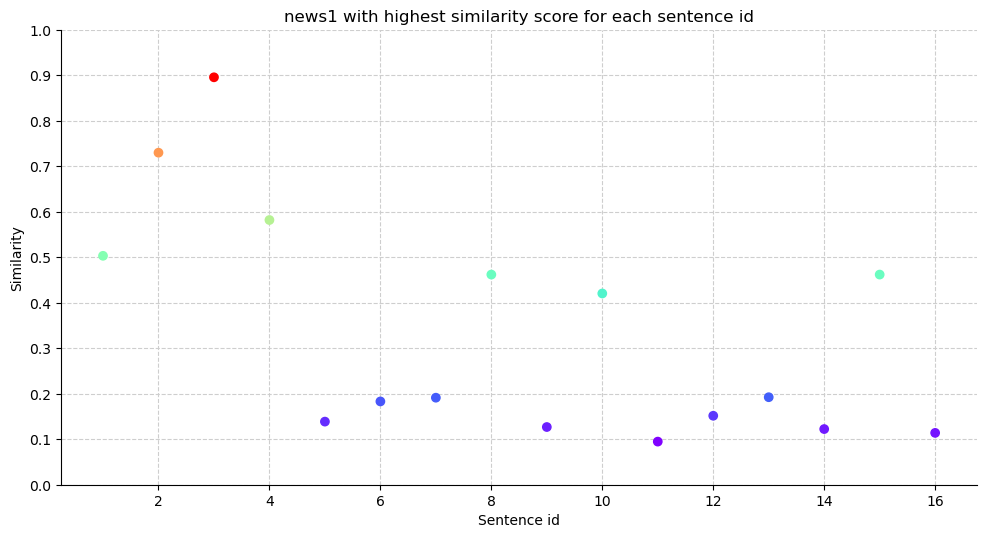

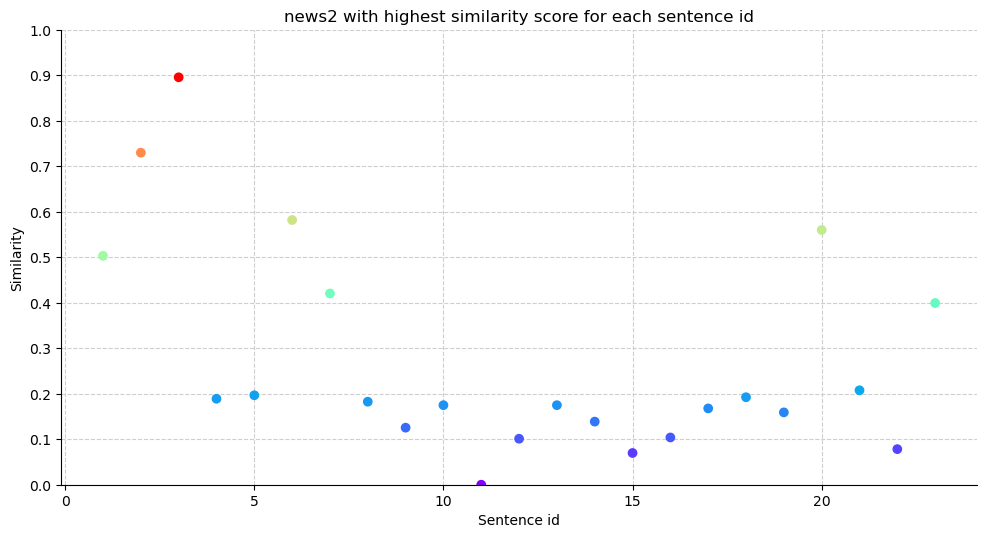

In [10]:
# graph max similarity matches for each sentence id
for each_source in cleaned_text['source'].unique():
    data_to_use = total_df1[total_df1['original_source'] == each_source]
    
    data_to_use = data_to_use.reset_index()
    
    # order by sentence and drop duplicates
    data_to_use = data_to_use.sort_values(by=['original_sentence', 'similarity'])
    data_to_use = data_to_use.drop_duplicates(subset=['original_sentence'], keep='last')
    
    # make scatterplot of similarity
    fig, ax = plt.subplots()
    ax.scatter(data_to_use['original_sentence_id'], data_to_use['similarity'], c=data_to_use['similarity'], cmap='rainbow')
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_ylabel("Similarity", size=10)
    ax.set_xlabel("Sentence id", size=10)
    ax.set_title(each_source+" with highest similarity score for each sentence id")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--', color='#CECECE')
    
    # save plot
    # set size of graph
    cmsize = 1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
    # save plot
    #plt.savefig(rf"{output_folder_images}\{each_source}"+"fig.png", dpi=400, bbox_inches='tight')

In [11]:
# get count of sentences by banding and compare to total number of sentences
count_bandings = total_df1
count_bandings['num'] = 1
count_bandings = count_bandings.groupby(['original_source','similarity_bandings'], as_index=False)['num'].count()

#total sentences
count_bandings_tot = count_bandings.groupby(['original_source'])['num'].sum().reset_index()
count_bandings_tot.rename(columns={'num':'tot'}, inplace=True)

# join
count_bandings = pd.merge(count_bandings, count_bandings_tot, how="left", left_on="original_source", right_on="original_source")

#get pct
count_bandings['pct'] = round((count_bandings['num']/count_bandings['tot'])*100,2)

# Bar graph of similarity bandings

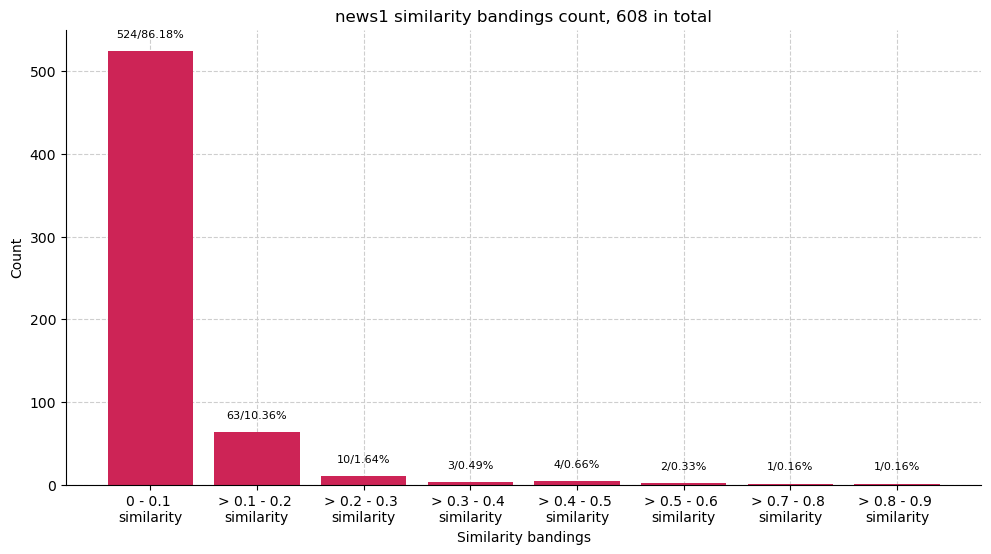

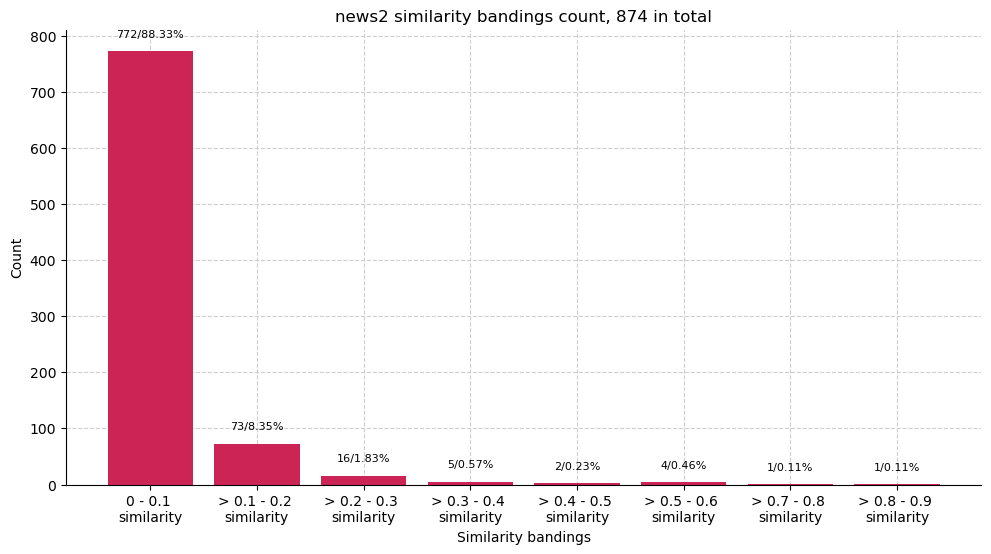

In [12]:
# bar graph of these
for each_source in count_bandings['original_source'].unique():
    data_to_use = count_bandings[count_bandings['original_source'] == each_source]
    
    #data_to_use = data_to_use.reset_index()
    #data_to_use['bandings_text'] = ['\n'.join(" ") for x in data_to_use['similarity_bandings']]
    
    # make bar chart
    fig, ax = plt.subplots()
    ax.bar(data_to_use['similarity_bandings'], data_to_use['num'], color='#CD2456')
    
    for x,y,z in zip(np.arange(0,len(data_to_use['similarity_bandings'])), data_to_use.num, data_to_use.pct):

        label = "{}".format(y) #"{:.2f}" 2 decimal places or round(y,0)
        label1 = "{}".format(z)


        plt.annotate(label+"/"+label1+"%", # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center',
                     rotation='horizontal', fontsize=8) # horizontal alignment can be left, right or center
        
    #ax.set_ylim(0,1)
    #ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_ylabel("Count", size=10)
    ax.set_xlabel("Similarity bandings", size=10)
    #ax.set_xticklabels(data_to_use['bandings_text'], rotation='horizontal',size=8)
    ax.set_title(each_source+" similarity bandings count, "+str(data_to_use['tot'].unique()[0])+" in total")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--', color='#CECECE')
    
    # save plot
    # set size of graph
    cmsize = 1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
    # save plot
    #plt.savefig(rf"{output_folder_images}\{each_source}"+"fig.png", dpi=400, bbox_inches='tight')

In [13]:
def extract_number(text):
    text = re.sub('\D+[^0-9]\s', ' ', text)

# heatmap (from bar graph count_bandings data)
count_bandings1 = count_bandings

count_bandings1['original_source1'] = (count_bandings1.index).astype(str)
#count_bandings1['original_source'] = count_bandings1['original_source'].apply(extract_number)

count_bandings1['numer'] = 1 

# Heatmap of similarity bandings

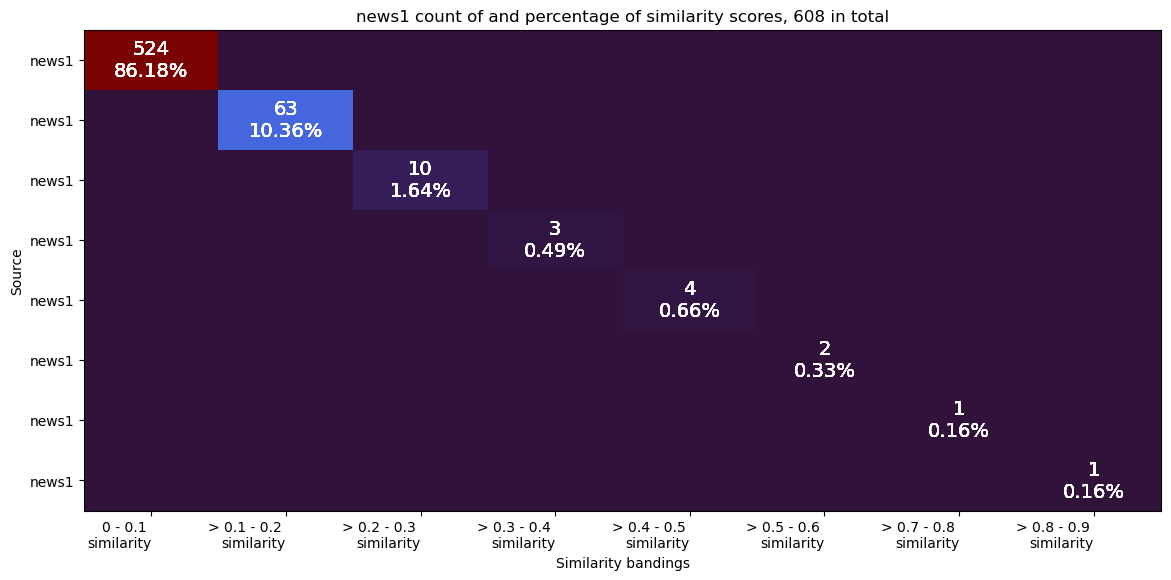

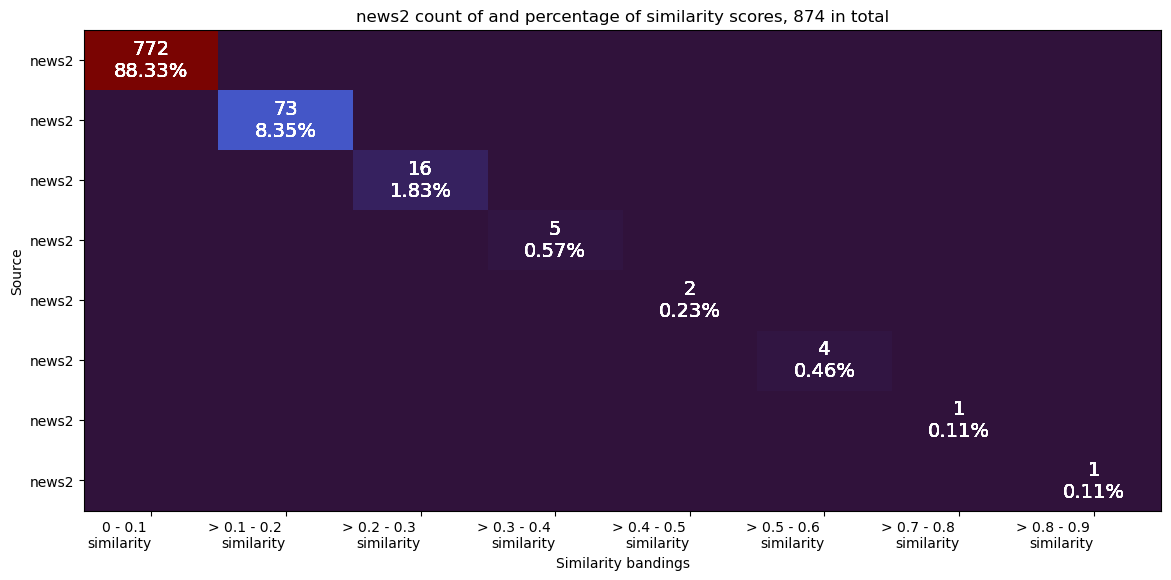

In [14]:
# heatmap for each source

for each_source in cleaned_text['source'].unique():
    
    count_bandings2 = count_bandings1[count_bandings1['original_source'] == each_source]
    
    # percentage matrix
    pct_mtrx = count_bandings2[['numer']].T.to_numpy() * count_bandings2[['pct']].to_numpy()
    
    diag = np.einsum('ii->i', pct_mtrx)
    # or if a is not guaranteed to be square
    # mn = min(a.shape)
    # diag = np.einsum('ii->i', a[:mn, :mn])
    save = diag.copy()
    pct_mtrx[...] = 0
    diag[...] = save
    
    # count matrix
    count_mtrx = count_bandings2[['numer']].T.to_numpy() * count_bandings2[['num']].to_numpy()
    
    diag1 = np.einsum('ii->i', count_mtrx)
    # or if a is not guaranteed to be square
    # mn = min(a.shape)
    # diag = np.einsum('ii->i', a[:mn, :mn])
    save1 = diag1.copy()
    count_mtrx[...] = 0
    diag1[...] = save1
    
    # make heatmap
    # set size of graph
    cmsize = 1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
    fig, ax = plt.subplots(figsize=(30*cmsize, 15*cmsize))
    im = ax.imshow(pct_mtrx, cmap='turbo', aspect='auto')
    #plt.colorbar()
    
    # show all ticks and label them with respective list entries
    ax.set_xticks(np.arange(len(count_bandings2['original_source'])), labels=count_bandings2['similarity_bandings'])#np.arange(len(count_bandings2['original_source'])))                                                                                                                         
    ax.set_yticks(np.arange(len(count_bandings2['original_source'])), labels=count_bandings2['original_source'])
    
    # rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor')
    
    # loop over the data dimensions and create text annotations
    for i in range(len(count_bandings2['original_source'])):
        for j in range(len(count_bandings2['original_source'])):
            text = ax.text(i,i, str(count_mtrx[i,i])+"\n"+str(float(pct_mtrx[i,i]))+"%", #int(pct_mtrx[i,i]),
                           ha='center', va='center', color='w', size=14)
    
    ax.set_xlabel('Similarity bandings',size=10)
    ax.set_ylabel('Source',size=10)        
    ax.set_title(each_source+" count of and percentage of similarity scores, "+str(count_bandings2['tot'].unique()[0])+" in total")
    fig.tight_layout()
    
    # save plot
    # set size of graph
    #cmsize = 1/2.54
    #fig.set_size_inches(30*cmsize, 15*cmsize)
    
    # save plot
    #plt.savefig(rf"{output_folder_images}\{each_source}"+"fig.png", dpi=400, bbox_inches='tight')

# Get top 2 similar sentences for each sentence of interest (original_sentence)

In [15]:
# get unique sentences
unique_sentences = total_df1['original_sentence'].unique()

# for each unique sentence, filter to top 2 similar and add results to a new df
top2 = pd.DataFrame()
for each_entry in unique_sentences:
    note = total_df1[total_df1['original_sentence'] == each_entry]
    
    # sort values
    note = note.sort_values(by=['similarity'], ascending = False)
    
    # get top 2
    note = note[0:2]
    
    # add to df
    top2 = pd.concat([top2, note], ignore_index = True)

# preview the data
top2.head(6)

,original_sentence,original_source,original_sentence_id,compared_sentence,compared_source,compared_sentence_id,similarity,original_sentence_words,compared_sentence_words,words_found,...,count_words_found,words_not_found,nbr_words_not_found,count_words_not_found,percent_words_found_o,percent_words_found_c,percent_words_not_found_o,percent_words_not_found_c,similarity_bandings,num
0,Scotland's economy secretary Màiri McAllan is ...,news1,1,Scotland's finance secretary Kate Forbes is pr...,news2,1,0.503412,18.0,20.0,"[scotland, summer, secretary, and, s, maternit...",...,13.0,"[confirmed, iri, mcallan, take, m, economy, this]",7.0,7.0,72.0,65.0,35.0,33.0,> 0.5 - 0.6 \nsimilarity,1
1,Scotland's economy secretary Màiri McAllan is ...,news1,1,She will remain Cabinet Secretary for Finance ...,news2,20,0.235514,18.0,22.0,"[and, secretary, take, economy, leave, will]",...,6.0,"[scotland, summer, confirmed, iri, s, mcallan,...",14.0,14.0,33.0,27.0,70.0,64.0,> 0.2 - 0.3 \nsimilarity,1
2,It will be the second time a serving Scottish ...,news1,2,It will be the first time a serving Scottish c...,news2,2,0.730209,21.0,15.0,"[cabinet, secretary, be, has, maternity, the, ...",...,14.0,"[second, kate, in, after, forbes, 2022, s, pre...",8.0,8.0,67.0,93.0,36.0,53.0,> 0.7 - 0.8 \nsimilarity,1
3,It will be the second time a serving Scottish ...,news1,2,Although Ms Forbes will be the first cabinet s...,news2,23,0.329812,21.0,30.0,"[in, cabinet, secretary, forbes, be, maternity...",...,10.0,"[second, kate, after, 2022, has, s, time, it, ...",12.0,12.0,48.0,33.0,55.0,40.0,> 0.3 - 0.4 \nsimilarity,1
4,Arrangements to cover Ms McAllan's ministerial...,news1,3,Arrangements to cover her ministerial responsi...,news2,3,0.895985,15.0,19.0,"[to, cover, responsibilities, be, out, ministe...",...,13.0,"[ms, mcallan, s]",3.0,3.0,87.0,68.0,19.0,16.0,> 0.8 - 0.9 \nsimilarity,1
5,Arrangements to cover Ms McAllan's ministerial...,news1,3,Ms Forbes has been finance secretary for two y...,news2,4,0.148010,15.0,19.0,"[first, ms, minister]",...,3.0,"[to, cover, responsibilities, s, mcallan, be, ...",13.0,13.0,20.0,16.0,81.0,68.0,> 0.1 - 0.2 \nsimilarity,1
